The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[INFO] Loaded 26 descriptor(s) from ./mapping_schemes
Selected mapping: ep_hdf5_flat_mapping_391
Score: 2


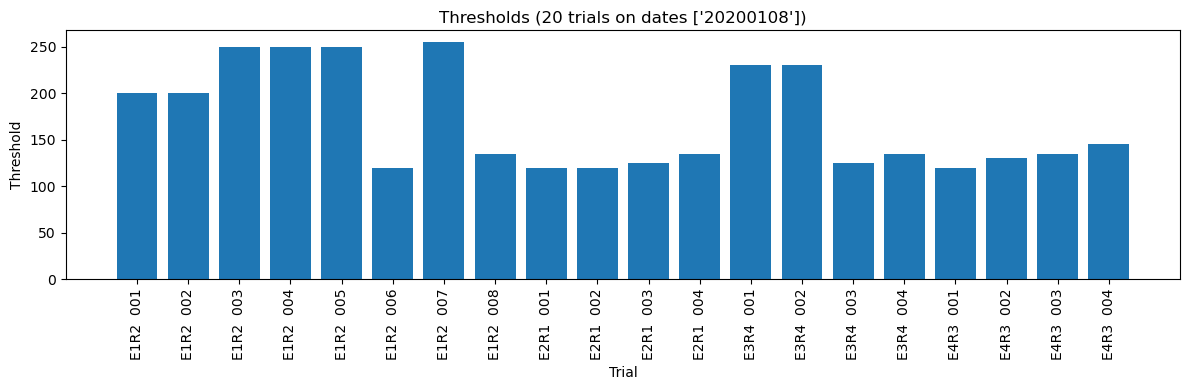

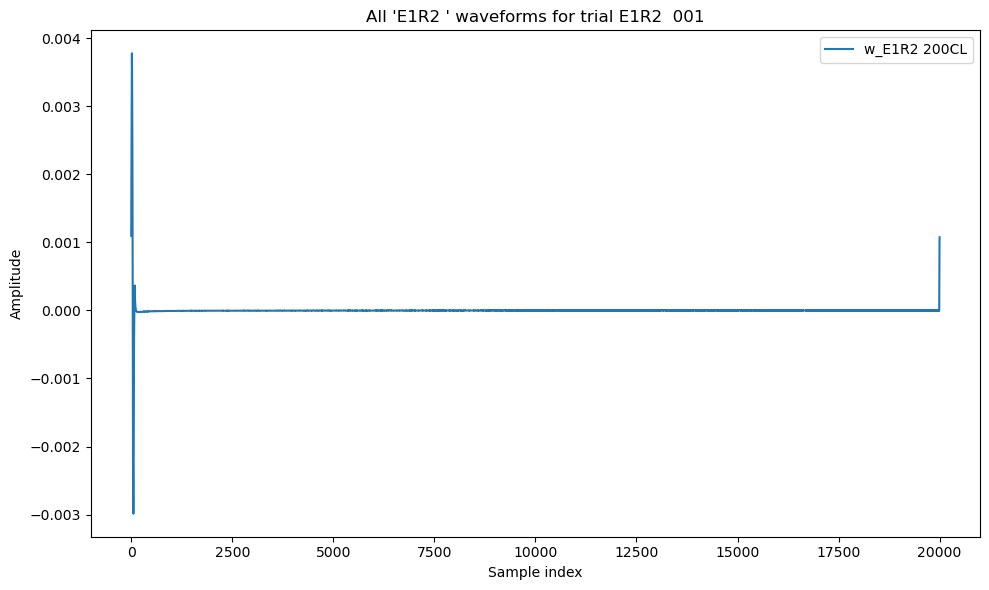

✅ Saved flattened trial records to: output\12_013.npz


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from utils import match_best_mapping, load_all_descriptors, save_standardized_output

# 1) Load descriptors & map file
descriptors = load_all_descriptors()
filepath    = "./downloads/12_013.h5"
filename    = Path(filepath).name

result = match_best_mapping(descriptors, filepath, sparc_id=391)
if result["descriptor"] is None:
    raise RuntimeError("No suitable mapping descriptor found.")

print("Selected mapping:", result["descriptor"]["id"])
print("Score:", result["score"])

res     = result["result"]
records = res["records"]
meta    = res["metadata"]

# 2) Bar-plot thresholds by trial
trials      = [r["trial"] for r in records]
thresholds  = [r["threshold"] for r in records]

plt.figure(figsize=(12, 4))
plt.bar(trials, thresholds)
plt.xlabel("Trial")
plt.ylabel("Threshold")
plt.title(f"Thresholds ({meta['n_records']} trials on dates {meta['dates']})")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3) Plot waveforms for the first record
first = records[0]
region = first["region"]
wave_keys = [k for k in first.keys()
             if k.startswith(f"w_{region}")]

plt.figure(figsize=(10, 6))
for wk in wave_keys:
    data = first[wk]
    plt.plot(data, label=wk)
plt.legend(loc="upper right")
plt.title(f"All '{region}' waveforms for trial {first['trial']}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 4) (Optional) Save your flat records to .npz
output_dir = Path("./output")
output_dir.mkdir(exist_ok=True, parents=True)
outpath = output_dir / filename.replace(".h5", ".npz")

# Here we’ll save the entire records list as a numpy object array
np.savez_compressed(
    outpath,
    records=np.array(records, dtype=object),
    metadata=meta,
)
print(f"✅ Saved flattened trial records to: {outpath}")


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Load the NPZ file ----
npz_path = Path("./output/12_013.npz")
data    = np.load(npz_path, allow_pickle=True)

# ---- Find all time/signals pairs ----
pairs = []
for key in data.files:
    if key.startswith("time"):
        suffix      = key[len("time"):]        # e.g. "" or "_hr" etc.
        signals_key = f"signals{suffix}"
        if signals_key in data:
            pairs.append((key, signals_key))

# ---- If none found, bail out ----
if not pairs:
    print("No time/signals arrays found in this NPZ. Nothing to plot.")
else:
    # ---- Create subplots ----
    n = len(pairs)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), squeeze=False)

    # ---- Loop and plot each pair ----
    for idx, (tkey, skey) in enumerate(pairs):
        t       = data[tkey]
        signals = data[skey]
        ax      = axes[idx, 0]

        # Plot each channel in this signal array
        for ch_idx, channel in enumerate(signals):
            ax.plot(t, channel, label=f"{skey}[{ch_idx}]")

        ax.set_title(f"{skey} vs {tkey}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(skey)
        ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

print(data['records'])

No time/signals arrays found in this NPZ. Nothing to plot.
[{'date': '20200108', 'region': 'E1R2 ', 'trial': 'E1R2  001', 'threshold': 200.0, 'levels': array([200.], dtype=float32), 'responses': array([2.749909e-06], dtype=float32), 'w_E1R2 200CL': array([0.00109628, 0.00116018, 0.00130082, ..., 0.000985  , 0.00102759,
        0.00107417], shape=(20000,), dtype=float32)}
 {'date': '20200108', 'region': 'E1R2 ', 'trial': 'E1R2  002', 'threshold': 200.0, 'levels': array([200.], dtype=float32), 'responses': array([3.8655003e-06], dtype=float32), 'w_E1R2 200CL': array([0.00099535, 0.00129692, 0.00161298, ..., 0.00072144, 0.00077368,
        0.00083801], shape=(20000,), dtype=float32)}
 {'date': '20200108', 'region': 'E1R2 ', 'trial': 'E1R2  003', 'threshold': 250.0, 'levels': array([200., 250., 255.], dtype=float32), 'responses': array([4.5990678e-06, 1.8040982e-05, 4.8879803e-05], dtype=float32), 'w_E1R2 200CL': array([0.00145222, 0.00154959, 0.00168071, ..., 0.00139995, 0.0014162 ,
     

In [ ]:
# In a Jupyter notebook cell:

import h5py

def print_hdf5_structure(group, indent=0):
    """
    Recursively print the members of an HDF5 group or file.
    - group:    an h5py.File or h5py.Group object
    - indent:   current indentation level (spaces)
    """
    for name, item in group.items():
        prefix = ' ' * indent
        if isinstance(item, h5py.Group):
            print(f"{prefix}Group:    {name}/")
            print_hdf5_structure(item, indent + 4)
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}Dataset:  {name}    shape={item.shape}    dtype={item.dtype}")
        else:
            print(f"{prefix}Unknown:  {name}    type={type(item)}")

# Usage
hdf5_path = "./downloads/12_013.h5"   # ← replace with your HDF5 filename
with h5py.File(hdf5_path, "r") as f:
    print(f"Contents of {hdf5_path}:")
    print_hdf5_structure(f)
